In [12]:
from DDPG.ddpg import DDPG
from DDPG.noise import UniformNoise
from DDPG.replay_memory import ReplayMemory, Transition

from Simulator.Constants import WIN_THRESHOLD, IMG_HEIGHT, IMG_WIDTH, NUM_FRAMES_STACKED
from Simulator.DriveEnv import DriveEnv

import torch
import numpy as np

In [13]:
epoch_num = 3300
checkpoint_file =  f"pretrained_models/ep_{epoch_num}.pth.tar"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = DriveEnv()
agent = DDPG(0, 0, [400, 300],
             IMG_HEIGHT * IMG_WIDTH * NUM_FRAMES_STACKED,
             env.action_space,
             )

agent.load_checkpoint(checkpoint_file)

Saving all checkpoints to ./saved_models/
Loading checkpoint...(pretrained_models/ep_3300.pth.tar)


Loaded model at timestep 3301 from pretrained_models/ep_3300.pth.tar


(3301, None)

In [14]:
def evaluate():
    agent.actor.eval()
    state = env.reset()
    memory = env.runEpisode(agent, None)
    return memory

In [15]:
memory = evaluate()
poses = [(i[0][3], i[0][4]) for i in env.controllerRecords]

#normalize poses to start at 0,0
# poses = [(i[0] - poses[0][0], i[1] - poses[0][1]) for i in poses]
currents = [(i[0][5], i[0][6]) for i in env.controllerRecords]
voltages = []

frames, rewards, next_frames, dones = [], [], [], []
for transition in memory:
    state, action, reward, next_state, done = transition
    frames.append(state.numpy()[3, :, :])
    rewards.append(reward)
    next_frames.append(next_state)
    dones.append(done)
    voltages.append(action.cpu().numpy())

#trim poses to length of frames
poses = poses[:len(frames)]
currents = currents[:len(frames)]

#convert voltages to range -12 to 12
voltages = [(i[0] * 12, i[1] * 12) for i in voltages]

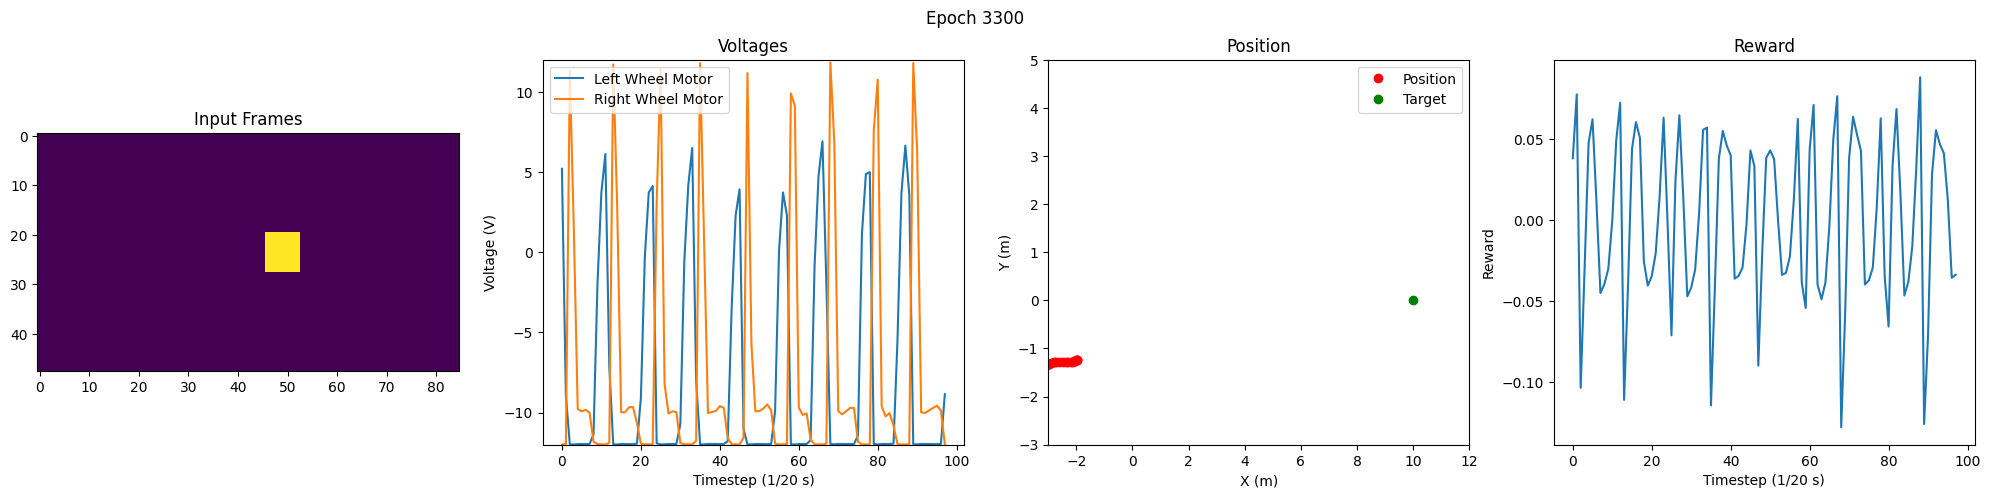

In [16]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

#create a combined figure of images and voltages using FuncAnimation
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))
fig.suptitle(f"Epoch {epoch_num}")
#set plot colors
def updatefig(i):
    #update image
    ax1.clear()
    ax1.set_title("Input Frames")
    ax1.imshow(frames[i])

    #update voltages
    ax2.clear()
    ax2.set_title("Voltages")
    ax2.set_xlabel("Timestep (1/20 s)")
    ax2.set_ylabel("Voltage (V)")
    ax2.set_ylim(-12, 12)
    ax2.plot([i[0] for i in voltages[:i]], label="Left Wheel Motor")
    ax2.plot([i[1] for i in voltages[:i]], label="Right Wheel Motor")
    ax2.legend()

    #update position
    ax3.clear()
    ax3.plot([i[0] for i in poses[:i]], [i[1] for i in poses[:i]], 'ro', label="Position")
    ax3.set_title("Position")
    ax3.set_xlabel("X (m)")
    ax3.set_ylabel("Y (m)")
    ax3.set_xlim(-10, 12)
    ax3.set_ylim(-10, 5)
    #plot target
    ax3.plot([10], [0], 'go', label="Target")
    ax3.legend()


    #update reward
    ax4.clear()
    ax4.plot(rewards[:i])
    ax4.set_title("Reward")
    ax4.set_xlabel("Timestep (1/20 s)")
    ax4.set_ylabel("Reward")

    return []

ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=70, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())

#save animation as mp4
ani.save(f"epoch_{epoch_num}.mp4")